# Random Forests

This notebook implements random forests, an ensemble method for classification or regression that constructs multiple decision trees and combined them to reach a single output.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions to help with training/testing endeavors and evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

# Import classification models
from sklearn.ensemble import RandomForestClassifier

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Training the model

First, I will be training the random forest model using the 5 predictors in my dataset. This is because `RandomForestClassifier` will give diagnostics about feature importance, so first I can see how this model performs and then try to improve the results by retraining the model on a subset of important features.

In [3]:
# Data preparation step
X = hawks[["Wing", "Tail", "Weight", "Culmen", "Hallux"]]
y = hawks["Species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

I choose `max_depth=3` because that is what I found to produce the best results.

In [4]:
forest_model = RandomForestClassifier(
    max_depth = 3, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model.fit(X_train, y_train)

print("Training accuracy:", forest_model.score(X_train, y_train))
print("Testing accuracy:", forest_model.score(X_test, y_test))

forest_y_pred = forest_model.predict(X_test)
print(f"Forest Classification Report")
print(classification_report(y_test, forest_y_pred), "\n")

Training accuracy: 0.9915730337078652
Testing accuracy: 0.9776536312849162
Forest Classification Report
              precision    recall  f1-score   support

          CH       0.92      0.85      0.88        13
          RT       0.98      1.00      0.99       106
          SS       0.98      0.97      0.97        60

    accuracy                           0.98       179
   macro avg       0.96      0.94      0.95       179
weighted avg       0.98      0.98      0.98       179
 



Overall, performance of this model is high, although the recall for Cooper's hawks (CH) could be better. However, based on the confusion matrix below, 

In [5]:
def plot_hawk_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    classes = ["RT", "CH", "SS"]
    cf_matrix = confusion_matrix(y_actual, y_pred, labels = classes)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt = 'g')
    ax.set_title('Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel("Predicted Label", fontsize = 12)
    ax.set_xticklabels(classes)
    ax.set_ylabel("True Label", fontsize = 12)
    ax.set_yticklabels(classes, rotation = 0)

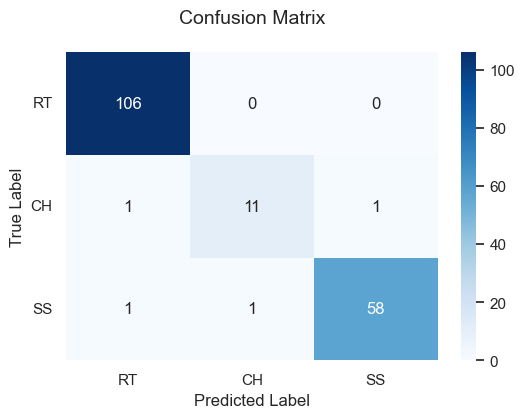

In [6]:
plot_hawk_confusion_matrix(y_test, forest_y_pred)
plt.show()

### Feature selection

In [7]:
# Output each feature's importance
for ft, imp in zip(X_train.columns, forest_model.feature_importances_):
    print(f"{abs(imp):.3f} - {ft}")

0.183 - Wing
0.067 - Tail
0.273 - Weight
0.295 - Culmen
0.181 - Hallux


In [8]:
trimmed_model = SelectFromModel(forest_model, prefit=True)
cols_keep = list(X_train.columns[trimmed_model.get_support()])
cols_drop = list(X_train.columns[~trimmed_model.get_support()])
print("Keeping:", cols_keep)
print("Dropping:", cols_drop)

Keeping: ['Weight', 'Culmen']
Dropping: ['Wing', 'Tail', 'Hallux']


In [9]:
# Create a subset of the X matrix with only the important features
X_train2 = X_train.drop(cols_drop, axis = 1)
X_test2 = X_test.drop(cols_drop, axis = 1)

forest_model2 = RandomForestClassifier(
    max_depth = 3, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model2.fit(X_train2, y_train)

print("Training accuracy:", forest_model2.score(X_train2, y_train))
print("Testing accuracy:", forest_model2.score(X_test2, y_test))

forest_y_pred2 = forest_model2.predict(X_test2)
print(f"Forest Classification Report")
print(classification_report(y_test, forest_y_pred2), "\n")

Training accuracy: 0.9915730337078652
Testing accuracy: 0.9720670391061452
Forest Classification Report
              precision    recall  f1-score   support

          CH       0.91      0.77      0.83        13
          RT       0.98      1.00      0.99       106
          SS       0.97      0.97      0.97        60

    accuracy                           0.97       179
   macro avg       0.95      0.91      0.93       179
weighted avg       0.97      0.97      0.97       179
 



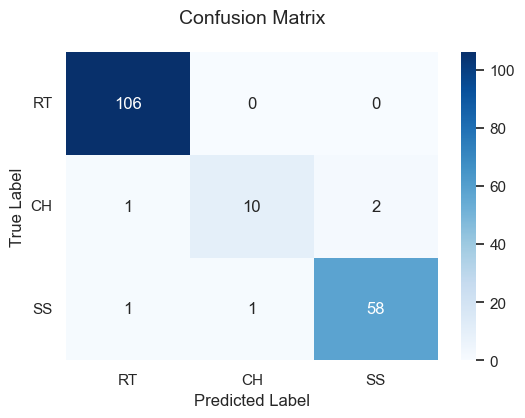

In [10]:
plot_hawk_confusion_matrix(y_test, forest_y_pred2)
plt.show()